# Titanic Survivor Project

## 타이타닉호의 생존자 데이터 분석 및 keras 를 활용한 생존율 예측 프로그램

1912년 침몰한 타이타닉호 생존 가능성 예측 프로그램입니다. 타이타닉호의 탑승자들의 데이터를 받고 정보에 따라 분석해서, keras로 학습합니다.<br>
또한, 학습모델을 플라스크 웹 서버와 연동하도록 구현하여,
서버에 접속하고 안내를 따라 사용자의 정보를 입력하면 타이타닉 호 침몰 시 해당 사용자의 생존 가능성을 계산하여 알려주는 프로그램입니다.

## 데이터 학습시키기
타이타닉호의 탑승자 데이터를 가져와 keras와 다층 선형 모델을 사용해 학습시켜 보겠습니다.

### 사용한 도구
사용한 언어: python<br>
사용한 라이브러리: 학습을 위한 keras (tensorflow backend), 데이터 분석 및 시각화를 위한 matplotlib, 파일을 읽어오기 위한 pandas, 그밖의 numpy 등<br>
데이터 출처: kaggle (https://www.kaggle.com/broaniki/titanic)

-------


먼저, 필요한 라이브러리들을 가져올 것입니다.<br>
파일을 읽어오는 pandas, plot을 그릴 수 있는 matplotlib와 tensorflow를 백엔드로 사용하는 Keras, 연산에 필요한 numpy를 import합니다.<br>
그 후 저장해둔 데이터를(excel파일) pandas를 사용해 읽어옵니다.

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 파일 읽어오기
raw_data = pd.read_excel('./data/titanic.xls')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


읽어온 데이터는 와 같이 14개의 columns, 즉 14개의 항목을 갖는 총 1309개 데이터임을 확인할 수 있습니다

이제, 이 데이터들 중 필요없는 데이터 및 부정확한 데이터를 제거하고 데이터 형식을 정리하는 일을 합니다.

In [10]:
# 성별 맞추기
tmp = []
for each in raw_data['sex']:
    if each == 'female':
        tmp.append(1)
    elif each == 'male':
        tmp.append(0)
    else:
        tmp.append(np.nan)

raw_data['sex'] = tmp

# 데이터 형식 맞추기
raw_data['survived'] = raw_data['survived'].astype('float')
raw_data['pclass'] = raw_data['pclass'].astype('float')
raw_data['sex'] = raw_data['sex'].astype('float')
raw_data['sibsp'] = raw_data['sibsp'].astype('float')
raw_data['parch'] = raw_data['parch'].astype('float')
raw_data['fare'] = raw_data['fare'].astype('float')

# 필요없는 데이터, 부정확한 데이터 제거
raw_data = raw_data[raw_data['age'].notnull()]
raw_data = raw_data[raw_data['sibsp'].notnull()]
raw_data = raw_data[raw_data['parch'].notnull()]
raw_data = raw_data[raw_data['fare'].notnull()]

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1045 non-null float64
survived     1045 non-null float64
name         1045 non-null object
sex          1045 non-null float64
age          1045 non-null float64
sibsp        1045 non-null float64
parch        1045 non-null float64
ticket       1045 non-null object
fare         1045 non-null float64
cabin        272 non-null object
embarked     1043 non-null object
boat         417 non-null object
body         119 non-null float64
home.dest    685 non-null object
dtypes: float64(8), object(6)
memory usage: 122.5+ KB


탑승객들의 성별을 남자는 0, 여자는 1로 바꾸어 분류하기 쉽게 만들었고, 항목마다 숫자는 float로 형태를 맞춰 주었습니다.<br>
NAN의 항목을 가진 데이터와 null(데이터가 없는)인 데이터를 제거하고 raw_data 를 재정비한 모습입니다. 데이터가 1045개로 줄었습니다.

생존율과 관련 없어보이는 항목들을 줄이고, 필요한 항목을 변인으로 설정합니다.<br>이 경우엔 데이터 중 pclass, sex, age, sibsp, parch, fare 이렇게 총 6개의 변인을 설정해서 x_data에 넣어주었습니다. 또한, 테스트용으로 10%의 데이터를 남겨두었습니다.

In [11]:
# 필요에 따라 6개의 변인 설정
x_data = raw_data.values[:, [0,3,4,5,6,8]]
y_data = raw_data.values[:, [1]]

# test용으로 10%의 데이터 남겨두기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.1, random_state=7)

이제 데이터를 학습시키기 위해 keras와 tensorflow 라이브러리를 import 합니다.

In [2]:
# import
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
np.random.seed(7)

# tensorflow version
print('tensorflow version : ', tf.__version__)
# keras version
print('keras version : ', keras.__version__)

tensorflow version :  1.13.1
keras version :  2.2.4


Using TensorFlow backend.


tensorflow가 벡엔드로 사용되고 있다면, 셀 실행시 위와같이 "Using TensorFlow backend"라는 메세지가 뜹니다. 만약 그렇지 않다면,
~~~
os.environ["KERAS_BACKEND"] = "tensorflow" 
~~~
위 코드로 설정해주어야 합니다.

이제 학습 학습시킬 모델을 설정해보겠습니다.

모델은 Sequential()이라는 순차모델을 사용합니다. 이는 선형적으로 차원을 쌓은 형태로, add() 메소드로 생성자에 dense()레이어를 붙여 모델을 생성할 수 있습니다.<br>
모델을 wide하게 하도록 첫번째 dense 레이어의 출력 노드는 255개, 입력값은 위에서 설정한 6개의 변인으로 설정하고,<br>활성화 함수를 은닉층 도출에 주로 쓰이는 rectifier 함수인 ReLu함수로 설정합니다. 두 번째 dense 레이어에는 출력층에 주로 쓰이는 sigmoid 함수를 적용합니다.

모델을 설정했으면, 모델을 학습 시키기전에 학습과정을 정의해야 하는데, 그 과정은 compile함수를 호출함으로서 완성됩니다.<br>
compile() 함수는 loss function, optimizer function과 metrics(평가 척도)를 인자로 갖습니다. 각각 알맞게 함수를 넣어주었는데, 가장 흔히 쓰이는 형식으로 넣어보았습니다.<br>(저희가 수업 시간에 사용한 함수는 Gradient Descendent 함수이지만, 속도가 느려진다는 단점이 있다고 합니다)

In [13]:
# 학습 모델 생성 및 함수 설정
model = Sequential()
model.add(Dense(255, input_shape=(6,), activation='relu'))
model.add(Dense((1), activation='sigmoid'))
model.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 255)               1785      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 256       
Total params: 2,041
Trainable params: 2,041
Non-trainable params: 0
_________________________________________________________________


summary()로 위와같이 생성된 모델을 확인할 수 있습니다.

이제 모델을 학습시켜 보겠습니다. keras에서는 모델을 fit함으로 학습시키는데,
모델이 학습하는 과정을 history로서 보여줍니다.

Train on 940 samples, validate on 105 samples
Epoch 1/500
940/940 [==============================] - 0s 228us/step - loss: 0.2957 - acc: 0.5957 - val_loss: 0.2208 - val_acc: 0.7048
Epoch 2/500
940/940 [==============================] - 0s 35us/step - loss: 0.2133 - acc: 0.6872 - val_loss: 0.1907 - val_acc: 0.7524
Epoch 3/500
940/940 [==============================] - 0s 35us/step - loss: 0.2045 - acc: 0.6989 - val_loss: 0.2012 - val_acc: 0.7429
Epoch 4/500
940/940 [==============================] - 0s 38us/step - loss: 0.1950 - acc: 0.7074 - val_loss: 0.1827 - val_acc: 0.7238
Epoch 5/500
940/940 [==============================] - 0s 36us/step - loss: 0.1818 - acc: 0.7436 - val_loss: 0.1704 - val_acc: 0.8000
Epoch 6/500
940/940 [==============================] - 0s 37us/step - loss: 0.1702 - acc: 0.7702 - val_loss: 0.1625 - val_acc: 0.7905
Epoch 7/500
940/940 [==============================] - 0s 37us/step - loss: 0.1715 - acc: 0.7543 - val_loss: 0.1646 - val_acc: 0.7810
Epoch 8/500
940

940/940 [==============================] - 0s 32us/step - loss: 0.1383 - acc: 0.8138 - val_loss: 0.1423 - val_acc: 0.8286
Epoch 122/500
940/940 [==============================] - 0s 37us/step - loss: 0.1333 - acc: 0.8234 - val_loss: 0.1388 - val_acc: 0.8476
Epoch 123/500
940/940 [==============================] - 0s 34us/step - loss: 0.1496 - acc: 0.7915 - val_loss: 0.1684 - val_acc: 0.7619
Epoch 124/500
940/940 [==============================] - 0s 34us/step - loss: 0.1519 - acc: 0.8000 - val_loss: 0.1616 - val_acc: 0.8000
Epoch 125/500
940/940 [==============================] - 0s 35us/step - loss: 0.1435 - acc: 0.8096 - val_loss: 0.1600 - val_acc: 0.7810
Epoch 126/500
940/940 [==============================] - 0s 32us/step - loss: 0.1376 - acc: 0.8138 - val_loss: 0.1420 - val_acc: 0.8095
Epoch 127/500
940/940 [==============================] - 0s 39us/step - loss: 0.1407 - acc: 0.8043 - val_loss: 0.1415 - val_acc: 0.8095
Epoch 128/500
940/940 [==============================] - 0s 38

940/940 [==============================] - 0s 29us/step - loss: 0.1307 - acc: 0.8213 - val_loss: 0.1413 - val_acc: 0.8476
Epoch 242/500
940/940 [==============================] - 0s 31us/step - loss: 0.1326 - acc: 0.8202 - val_loss: 0.1639 - val_acc: 0.8190
Epoch 243/500
940/940 [==============================] - 0s 29us/step - loss: 0.1318 - acc: 0.8213 - val_loss: 0.1658 - val_acc: 0.8095
Epoch 244/500
940/940 [==============================] - 0s 34us/step - loss: 0.1297 - acc: 0.8330 - val_loss: 0.1481 - val_acc: 0.7810
Epoch 245/500
940/940 [==============================] - 0s 32us/step - loss: 0.1287 - acc: 0.8223 - val_loss: 0.1440 - val_acc: 0.8381
Epoch 246/500
940/940 [==============================] - 0s 33us/step - loss: 0.1383 - acc: 0.8138 - val_loss: 0.1434 - val_acc: 0.8000
Epoch 247/500
940/940 [==============================] - 0s 34us/step - loss: 0.1365 - acc: 0.8191 - val_loss: 0.1416 - val_acc: 0.8286
Epoch 248/500
940/940 [==============================] - 0s 32

940/940 [==============================] - 0s 32us/step - loss: 0.1310 - acc: 0.8128 - val_loss: 0.1477 - val_acc: 0.8286
Epoch 362/500
940/940 [==============================] - 0s 34us/step - loss: 0.1269 - acc: 0.8298 - val_loss: 0.1465 - val_acc: 0.8381
Epoch 363/500
940/940 [==============================] - 0s 35us/step - loss: 0.1261 - acc: 0.8362 - val_loss: 0.1478 - val_acc: 0.8286
Epoch 364/500
940/940 [==============================] - 0s 33us/step - loss: 0.1251 - acc: 0.8319 - val_loss: 0.1753 - val_acc: 0.8000
Epoch 365/500
940/940 [==============================] - 0s 35us/step - loss: 0.1291 - acc: 0.8245 - val_loss: 0.1470 - val_acc: 0.8095
Epoch 366/500
940/940 [==============================] - 0s 31us/step - loss: 0.1245 - acc: 0.8351 - val_loss: 0.1799 - val_acc: 0.8095
Epoch 367/500
940/940 [==============================] - 0s 32us/step - loss: 0.1315 - acc: 0.8277 - val_loss: 0.1494 - val_acc: 0.8095
Epoch 368/500
940/940 [==============================] - 0s 33

940/940 [==============================] - 0s 34us/step - loss: 0.1223 - acc: 0.8319 - val_loss: 0.1674 - val_acc: 0.8095
Epoch 482/500
940/940 [==============================] - 0s 32us/step - loss: 0.1198 - acc: 0.8447 - val_loss: 0.1523 - val_acc: 0.8000
Epoch 483/500
940/940 [==============================] - 0s 34us/step - loss: 0.1191 - acc: 0.8383 - val_loss: 0.1579 - val_acc: 0.8095
Epoch 484/500
940/940 [==============================] - 0s 41us/step - loss: 0.1235 - acc: 0.8362 - val_loss: 0.1591 - val_acc: 0.7905
Epoch 485/500
940/940 [==============================] - 0s 39us/step - loss: 0.1341 - acc: 0.8160 - val_loss: 0.1633 - val_acc: 0.7810
Epoch 486/500
940/940 [==============================] - 0s 41us/step - loss: 0.1228 - acc: 0.8340 - val_loss: 0.1488 - val_acc: 0.8286
Epoch 487/500
940/940 [==============================] - 0s 35us/step - loss: 0.1219 - acc: 0.8351 - val_loss: 0.1671 - val_acc: 0.7810
Epoch 488/500
940/940 [==============================] - 0s 36

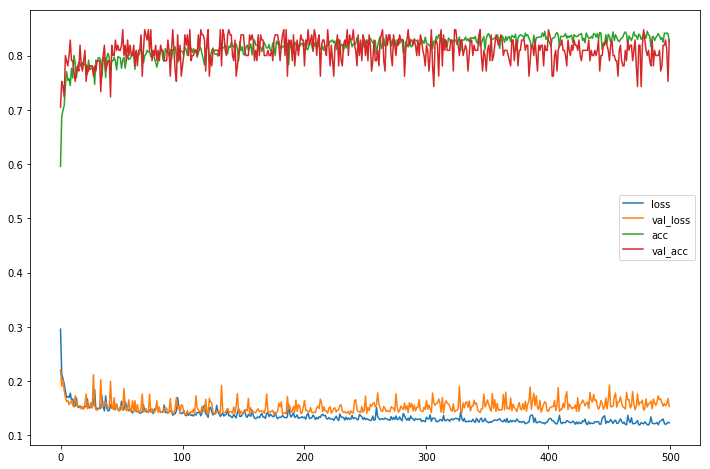

In [14]:
# 학습 fitting
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500)

# 학습 과정 보여주기
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['loss','val_loss', 'acc','val_acc'])
plt.show()

학습의 accuracy를 높이고 loss를 줄이기 위해 epoch은 500정도로 크게 설정하였고, 최종 모델의 loss는 0.12, 정확도는 약 85% 정도로 나왔습니다.

이제 학습된 모델을 저장합니다. h5파일은 keras에서 흔히 쓰이는 파일로, 이때 저장된 모델에는 나중에 모델을 재구성하기 위한 모델의 구성 정보, 모델을 구성하는 각 뉴런들의 가중치, 모델의 마지막 학습 상태가 저장되어있습니다. 

In [15]:
# 모델 저장
from keras.models import load_model
model.save('saved_model.h5')
print('Model is saved.')

Model is saved.


여기까지 하면 모델의 학습 및 저장이 완료된 것입니다.

In [16]:
# 실제 변수 예측
dicaprio = np.array([3, 0, 19, 0, 0, 5]).reshape(1,6)
model.predict(dicaprio)

array([[0.11168811]], dtype=float32)

추가로 영화 타이타닉의 주인공인 레오나르도 디카프리오의 생존율이 궁금해 예측해 보았습니다.

자료에 따르면 디카프리오는 3등석에 탑승했고, 19살 남성이었으며, 형제 자매 부모가 없었고 총 운임은 5불을 냈습니다. 그의 생존율은 0.11, 즉 11퍼센트 정도로 매우 낮게 나왔습니다. 2019년의 데이터 분석과 머신러닝 기술상으로도, 디카프리오는 살 수 없는 운명이었나 봅니다.